In [1]:
from GridWorld_EnvironmentPPO import AstroidGrid
import numpy as np
import torch.nn as nn
import torch 
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import torch.distributions  as D
import time 
import matplotlib.pyplot as plt

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Proximal Policy Optimization 

Things we need to build:
    
- Are two neural networks in an actor critic style PPO


> one that calculates the current policy action policies given some current state (given random batch of experiences), it should output a softmax of size (actions,1), where each activation is the probability of taking that action in that state
    
> one that calculates the baseline reward estimate used to compute the advantage (given random batch of experiences), with network output being a linear activation function 
    
    
- A memory class 

- A agent class that updates the memory, calculates GAE, calculates loss, iterates through epochs of gradient ascent so the policy network and value network can generalize the complex function which governs the policy and value estimation of the environment, respectivly.

In [2]:
class ActorNetwork(nn.Module):
    
    def __init__(self,input_dims,action_dims,fc1_dims=256,fc2_dims=256,alpha=0.0004):
        super().__init__()
        self.input_dims = input_dims
        self.actions_dims = action_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        
        
        
        
        self.fc1 = nn.Linear(self.input_dims,self.fc1_dims)
        
        self.fc2 = nn.Linear(self.fc1_dims,self.fc2_dims)
        
        self.linear_out = nn.Linear(self.fc2_dims,action_dims)
        

        #ADAM Optimizer
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.optimizer = torch.optim.Adam(self.parameters(), lr=alpha)
        self.to(self.device)
    
        
        

    def forward(self,states):
        
        out = F.relu(self.fc1(states))        
        out = F.relu(self.fc2(out))
        out = self.linear_out(out)
        
        #Out is dimensions of output from FC2, which is the dimension of the number of discrete actions in our environment
        out = F.softmax(out,-1)
        
    
        
        
        return out
        
        
        
        
        

In [3]:
class CriticNetwork(nn.Module):
    
    def __init__(self,input_dims,fc1_dims=256,fc2_dims=256,alpha=0.0004):
        super().__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        
    
        self.fc1 = nn.Linear(self.input_dims,self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims,self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims,1)
        

        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.optimizer = torch.optim.Adam(self.parameters(), lr=alpha)
        self.to(self.device)
    
    def forward(self,state):
        
        out = F.relu(self.fc1(state))        
        out = F.relu(self.fc2(out))        
        output = self.fc3(out) #Output is size zero of baseline reward (1,1)
        
        
        return output
        
        
        

In [4]:
#This class has been copied from this github repo:
#https://github.com/philtabor/Youtube-Code-Repository/blob/master/ReinforcementLearning/PolicyGradient/PPO/torch/ppo_torch.py


class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

        self.batch_size = batch_size

    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return np.array(self.states),\
                np.array(self.actions),\
                np.array(self.probs),\
                np.array(self.vals),\
                np.array(self.rewards),\
                np.array(self.dones),\
                batches

    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []

### PPO with Clipped Objective Function 

#### METHODS:

    > Forward calculation of actor network given a state to calculate the policy (new) 
    
    
    > Calculate the loss function given policy new, policy old, advantage, clipping params
    
    
    > Calculate the GAE of a state history given the reward history and output from our value network
    
    
    > Learning Loop where we iterate through batches from stored memory for a number of PPO Epochs, and batches, then clear the batch memory at the end using the method in the PPO Memory class from above

In [13]:
#implementation using Clipped Surrogate Objective PPO actor critic style


class AgentPPO():
    """HyperParameter / Parameters needed for implementation
    NEEDED: 
    
    Size action space
    
    size of the observations of the environment
    
    
    LAMBDA      
    GAMMA                                
    EPSILION   
    BATCHSIZE 
    NUM_EPOCHS                            
                 
    
    
    """
    
    
    
    
    
    
    
    
    def __init__(self,size_state_array,size_action_space,lambda1,epsilon,gamma,batchsize,epochs):
        
        self.state_size = size_state_array
        self.action_space = size_action_space
        
        self.critic    = CriticNetwork(self.state_size)
        self.actor     = ActorNetwork(self.state_size,self.action_space)

        
       
        
    
        
        
        
        
        #Learning Parameters
        
        self.lambda1 = lambda1
        self.epsilon = epsilon 
        self.gamma = gamma
        self.batchsize = batchsize 
        self.numepochs = epochs
        
        
        
        self.memory    = PPOMemory(self.batchsize)
        
        
        self.total_loss_out = []
        
        
        
    def get_action_dist(self,state_tensor):
        #Forward calculation given the states in the batch
        net_out  = self.actor(state_tensor)
        
        #Creates a categorical disturbution 
        dist = D.Categorical(net_out)
        
        
        
        return dist
        
    
    
    
    def calc_lossCPI(self,old_probs,curr_probs,value,curr_returns,entropy):
        #Tensor -> Old_Probs
        #Tensor -> New_Probs 
        #Tensor  -> Value
        #Curr Returns needs to be converted to tensor

        
        
        returnz_tensor = torch.FloatTensor(curr_returns).to(device)
        

        advantage      = torch.subtract(value.reshape_as(returnz_tensor),returnz_tensor)
        
        #We have log probabilities so subtraction the raising e to the power of the subtraction is same as ratio
        old_new_ratio  = (curr_probs - old_probs).exp() 
       
        
        #R_theta ratio of new to old probs, loss without clipping
        RA             = torch.mul(old_new_ratio,advantage) #R_theta * Advantage 

        #Clipped ratio x advantage 
        RA_clipped     = torch.mul(torch.clamp(old_new_ratio,1-self.epsilon,1+self.epsilon),advantage)
        
        #Mean of the min of ra and ra_clipped x -1
        LossCPI        = -1*torch.mean(torch.min(RA,RA_clipped)) #Using torch mean as its the expected value of the min, -1* because we want to preform gradient ascent 
        
        #MSE of advantage (value estimate - GAE returns)
        Loss_Critic    =  torch.mean(torch.square(advantage)) #Stays positive as we are aiming to minimize this
        
     
        Total_Loss     = LossCPI+0.5*Loss_Critic  - 0.0001*entropy



        self.total_loss_out.append(Total_Loss.detach().cpu().numpy().item())
        
        return LossCPI,Loss_Critic,Total_Loss 
    
    def learning(self):
        # We Need two for loops 1 for PPOEPOCHS (first loop in algo),
        # then a second loop for batches to preform backprop on
        for _ in range(self.numepochs):
            state_arr, action_arr, old_prob_arr, vals_arr,\
            reward_arr, dones_arr, batches = \
                    self.memory.generate_batches()
            
            #Estimate Return using GAE method
            true_returns = self.calc_advantage(vals_arr,reward_arr,dones_arr)

        

           
            
            #returns_norm = (true_returns - np.mean(true_returns))/np.std(true_returns)
            
            #Now iteration through batches
            for batch in batches: 
                
                
                state =  state_arr[batch]#Numpy array of observations 
                
                state_tensor = torch.FloatTensor(state).to(device)
                
                
                dist  = self.get_action_dist(state_tensor) #discrete PDF of actions for current state from Policy Network (Actor)
                value = self.critic(state_tensor)   #Value from Value Network (Critic)
                
                #Sample the acton PDF to get action 
                action_curr = dist.sample()
                
                #Stored action from previous policy for that batch
                action_old =  torch.FloatTensor(action_arr[batch]).to(device)
                
        
                
                
                
                
                old_probs                    = torch.FloatTensor(old_prob_arr[batch]).to(device)              
                curr_probs                   = dist.log_prob(action_curr).reshape_as(old_probs)
                entropy                      = dist.entropy().mean()
             
            
                returnz                      = true_returns[batch]  
                


                
                loss_actor,loss_critic,total_loss = self.calc_lossCPI(old_probs,curr_probs,value,returnz,entropy)
             



                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()
                
                
                
          
                
                
               
                
                
            
            
        self.memory.clear_memory()
         
                
    
    def calc_advantage(self,values,rewards,dones):
        #rewards  = np.interp(rewards, (-1000, 2000), (0, 1))
        # Following algorithim described in https://www.youtube.com/watch?v=WxQfQW48A4A&ab_channel=SkowstertheGeek
        #GAE Algorithim 
        
            # MASK is 0 if state is terminal, which is convention.. so we need to use 1-done
            # GAE is 0 initally
            # Loop through all of the calculated rewards in reverse order so  k = len(rewards)-ind
            #(IN LOOP) Calculate Delta 
            #(IN LOOP) Calculate GAE
            #(IN LOOP) Calculate Return
            #Add Return to our list of returns 
            #Then Calculate the Final Return outside of the loop (This isnt discussed in the youtube video but I cant see how Return Final Is calculated)
            
        
        
        returns = []
        
        gae        = 0 
        
        

        for k in reversed(range(len(rewards)-1)): 
            mask = 1 - dones[k]
            
            delta = rewards[k] + self.gamma * values[k] * mask - values[k+1]
            
            
            gae = delta  + self.lambda1*self.gamma*mask*gae 
            
            return_ = gae+values[k+1]
            returns.append(return_)
            
        
        
        returns = list(reversed(returns)) 
        #This should only take us to our penultimate state, because its len rewards -1 
        # So we need to calculate the final delta where mask = 0
        
        delta_final = rewards[-1] + values[-2] #Values of S' is 0 because its terminal
        
        #And mask =0 
        #So...
        
        gae_final  = delta_final #Mask is 0 so gae final = delta 
        
        return_final = gae+values[-2]
        
        returns.append(return_final)
    
        ### *** Redundant to have written out the final step for k = 0, as mask would have been 0 but should effect result
        return np.array(returns)
            
            
    
        
        
        
        
        
        
        
        
        
        
        

#### TESTING PPO:

Gridworld:

In [135]:
#torch.manual_seed(99)

In [ ]:
tic = time.time()
episodes = 500
env      = AstroidGrid(10,10,5,0,rand_locs=False,fuel=200)
env.reset_env()
agent = AgentPPO(2,4,lambda1 = 0.95,epsilon=0.2,gamma=0.9,batchsize=50,epochs=20)
N= 100

print(env.environment)

store_rewards = []
store_mean_rewards = []
episode_counter = 0
learn_iterz = 0
for _ in range(episodes):
    env.reset_env()
    
    cum_reward = 0
    
    done = False
    
    
    while done != True: 
    
        curr_state = env.calc_obs().reshape(1,2)
        curr_state  = np.interp(curr_state, (0, 10), (0, 1))

        state_tensor = torch.FloatTensor(curr_state).to(device)
        
        dist1 = agent.get_action_dist(state_tensor)
        dist = torch.squeeze(dist1.log_prob(dist1.sample())).item()
        
        action = torch.squeeze(dist1.sample()).item()
        action1 = dist1.sample()
         
        value = agent.critic(state_tensor)
        value = value.detach().cpu().numpy().item() # WE NEED FLOAT not TENSOR FOR GAE 
        #print(value)
        
        ind = action1.cpu().numpy().item()
        reward,_,_,_,done = env.take_action(env.action_list[ind])
     
        agent.memory.store_memory(curr_state,action,dist,value,reward,done)
        
        #VALUE = TENSOR ALREADY
        #ACTION = Categorical(probs: torch.Size([1, 5])) This is already correct 
 
        learn_iterz += 1
        
        
        if learn_iterz % N==0:
            
            agent.learning()
        
        
        cum_reward += reward
        
    
    episode_counter +=1   
    store_rewards.append(cum_reward)
    store_mean_rewards.append(np.mean(store_rewards))

    if episode_counter%100 == 0:
      print("Episode {} Complete".format(episode_counter))    

toc = time.time()

print("Elapsed time: {} Seconds".format(round(toc-tic)))

five_ep_smoothed_rew = np.convolve(store_rewards, np.ones(10)/10, mode='valid')
episode_arr = np.array(range(episodes))
rewards_hist  = np.array(store_rewards)
AVGrewards_hist  = np.array(store_mean_rewards)
plt.plot(rewards_hist)
plt.show()
plt.plot(AVGrewards_hist)
plt.show()

Cartpole:

In [15]:
import gym
torch.manual_seed(99)

In [39]:
episodes = 500
env = gym.make('CartPole-v1')
agent = AgentPPO(4,2,lambda1 = 0.96,epsilon=0.2,gamma=0.98,batchsize=100,epochs=100)
N= 200 #Needs to be less than the episode length, assume max episode length
learn_iterz = 0

store_rewards = []
store_mean_rewards = []
for i in range(episodes):
    obs = env.reset()
    
    cum_reward = 0
    
    done = False
    
    
    
    while done != True: 
     
        
        #print(state_tensor)
        
        state_tensor = torch.FloatTensor(obs).to(device)
        
        dist1 = agent.get_action_dist(state_tensor)
        
        dist = torch.squeeze(dist1.log_prob(dist1.sample())).item()
        
        action = torch.squeeze(dist1.sample()).item()
        
        
        value = agent.critic(state_tensor)
        value = value.cpu().detach().numpy().item() # WE NEED FLOAT not TENSOR FOR GAE 
        
        
    
        obs, reward, done, info = env.step(action)
        
      
        
        
           
        agent.memory.store_memory(obs,action,dist,value,reward,done)
        
        #VALUE = TENSOR ALREADY
        #ACTION = Categorical(probs: torch.Size([1, 5])) This is already correct 
    
        
        
        learn_iterz += 1
        
        #
        if learn_iterz % N==0:
            
            agent.learning()
        
        
        cum_reward += reward
    
    if cum_reward > 200: #Threshold for solving the environment 
        print('greater than 200')
        break
       
    store_rewards.append(cum_reward)
    store_mean_rewards.append(np.mean(store_rewards))

  




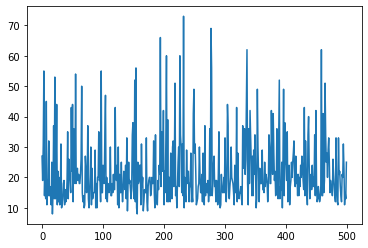

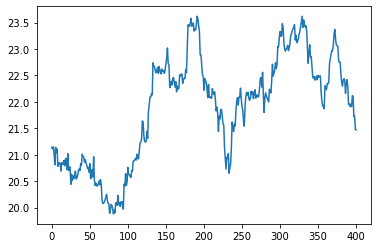

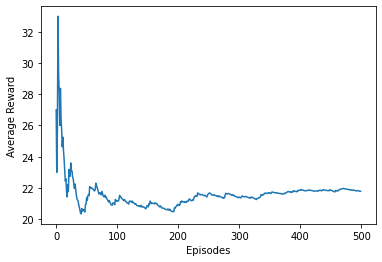

21.784
10.923430962843131


Text(0, 0.5, 'Total Loss (CPI + VF + Entropy)')

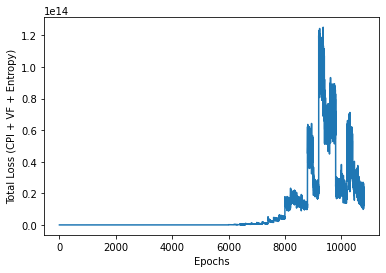

In [40]:

five_ep_smoothed_rew = np.convolve(store_rewards, np.ones(100)/100, mode='valid')
episode_arr = np.array(range(episodes))
rewards_hist  = np.array(store_rewards)
AVGrewards_hist  = np.array(store_mean_rewards)
plt.plot(rewards_hist)
plt.show()
plt.plot(five_ep_smoothed_rew)
plt.show()
plt.plot(AVGrewards_hist)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.show()
print(np.mean(rewards_hist))
print(np.std(rewards_hist))
plt.plot(agent.total_loss_out)
plt.xlabel('Epochs')
plt.ylabel('Total Loss (CPI + VF + Entropy)')

In [49]:

#DECREASING EPSILON 
episodes = 2000
env = gym.make('CartPole-v1')
agent = AgentPPO(4,2,lambda1 = 0.96,epsilon=0.1,gamma=0.98,batchsize=100,epochs=50)
N= 200 #Needs to be less than the episode length, assume max episode length
learn_iterz = 0

store_rewards = []
store_mean_rewards = []
for i in range(episodes):
    obs = env.reset()
    
    cum_reward = 0
    
    done = False
    
    
    
    while done != True: 
     
        
        #print(state_tensor)
        
        state_tensor = torch.FloatTensor(obs).to(device)
        
        dist1 = agent.get_action_dist(state_tensor)
        
        dist = torch.squeeze(dist1.log_prob(dist1.sample())).item()
        
        action = torch.squeeze(dist1.sample()).item()
        
        
        value = agent.critic(state_tensor)
        value = value.cpu().detach().numpy().item() # WE NEED FLOAT not TENSOR FOR GAE 
        
        
    
        obs, reward, done, info = env.step(action)
        
      
        
        
           
        agent.memory.store_memory(obs,action,dist,value,reward,done)
        
        #VALUE = TENSOR ALREADY
        #ACTION = Categorical(probs: torch.Size([1, 5])) This is already correct 
    
        
        
        learn_iterz += 1
        
        #
        if learn_iterz % N==0:
            
            agent.learning()
        
        
        cum_reward += reward
    
    if cum_reward > 200: #Threshold for solving the environment 
        print('greater than 200')
        break
       
    store_rewards.append(cum_reward)
    store_mean_rewards.append(np.mean(store_rewards))

  


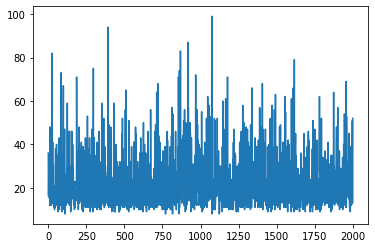

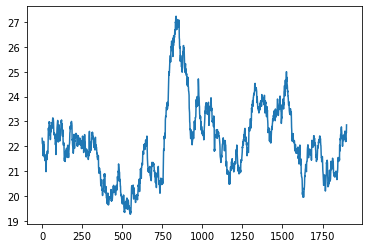

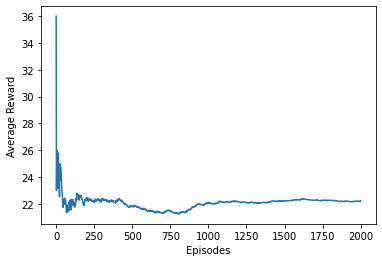

22.2035
11.855424401935174


Text(0, 0.5, 'Total Loss (CPI + VF + Entropy)')

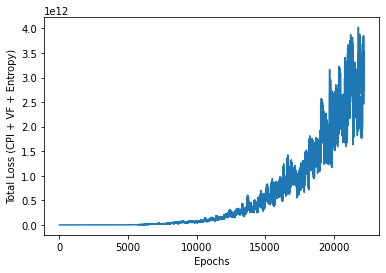

In [50]:
#DECREASING EPSILION 
five_ep_smoothed_rew = np.convolve(store_rewards, np.ones(100)/100, mode='valid')
episode_arr = np.array(range(episodes))
rewards_hist  = np.array(store_rewards)
AVGrewards_hist  = np.array(store_mean_rewards)
plt.plot(rewards_hist)
plt.show()
plt.plot(five_ep_smoothed_rew)
plt.show()
plt.plot(AVGrewards_hist)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.show()
print(np.mean(rewards_hist))
print(np.std(rewards_hist))
plt.plot(agent.total_loss_out)
plt.xlabel('Epochs')
plt.ylabel('Total Loss (CPI + VF + Entropy)')

In [121]:
store_rewards = []
mean_rewards  = [] 
env = gym.make('CartPole-v1')
for i in range(500):
    obs = env.reset()
    
    cum_reward = 0
    
    done = False
    
    
    
    while done != True: 
        obs, reward, done, info = env.step(env.action_space.sample())


        cum_reward += reward
    mean_rewards.append(np.mean(store_rewards))
    store_rewards.append(cum_reward)

    

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


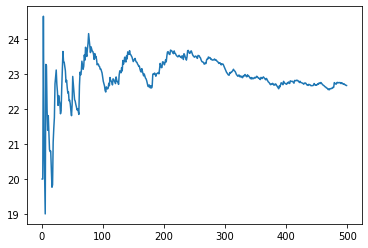

In [122]:
plt.plot(mean_rewards)

In [53]:

#DECREASING EPSILON 
episodes = 500
env = gym.make('CartPole-v1')
agent = AgentPPO(4,2,lambda1 = 0,epsilon=0.1,gamma=0,batchsize=100,epochs=50)
N= 200 #Needs to be less than the episode length, assume max episode length
learn_iterz = 0

store_rewards = []
store_mean_rewards = []
for i in range(episodes):
    obs = env.reset()
    
    cum_reward = 0
    
    done = False
    
    
    
    while done != True: 
     
        
        #print(state_tensor)
        
        state_tensor = torch.FloatTensor(obs).to(device)
        
        dist1 = agent.get_action_dist(state_tensor)
        
        dist = torch.squeeze(dist1.log_prob(dist1.sample())).item()
        
        action = torch.squeeze(dist1.sample()).item()
        
        
        value = agent.critic(state_tensor)
        value = value.cpu().detach().numpy().item() # WE NEED FLOAT not TENSOR FOR GAE 
        
        
    
        obs, reward, done, info = env.step(action)
        
      
        
        
           
        agent.memory.store_memory(obs,action,dist,value,reward,done)
        
        #VALUE = TENSOR ALREADY
        #ACTION = Categorical(probs: torch.Size([1, 5])) This is already correct 
    
        
        
        learn_iterz += 1
        
        #
        if learn_iterz % N==0:
            
            agent.learning()
        
        
        cum_reward += reward
    
    if cum_reward > 200: #Threshold for solving the environment 
        print('greater than 200')
        break
       
    store_rewards.append(cum_reward)
    store_mean_rewards.append(np.mean(store_rewards))


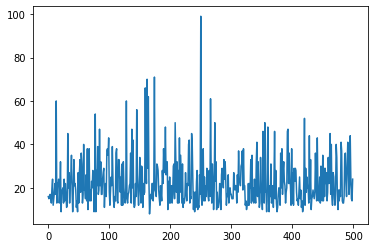

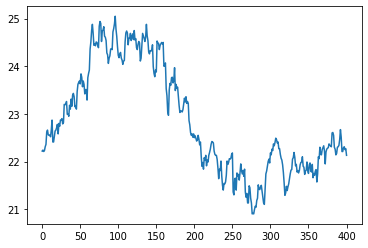

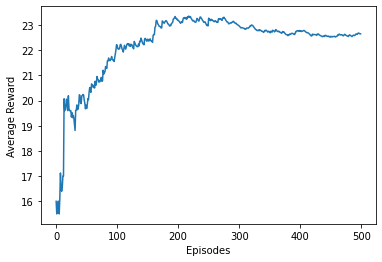

22.652
11.287111942388096


Text(0, 0.5, 'Total Loss (CPI + VF + Entropy)')

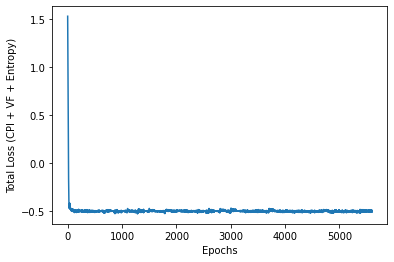

In [54]:
five_ep_smoothed_rew = np.convolve(store_rewards, np.ones(100)/100, mode='valid')
episode_arr = np.array(range(episodes))
rewards_hist  = np.array(store_rewards)
AVGrewards_hist  = np.array(store_mean_rewards)
plt.plot(rewards_hist)
plt.show()
plt.plot(five_ep_smoothed_rew)
plt.show()
plt.plot(AVGrewards_hist)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.show()
print(np.mean(rewards_hist))
print(np.std(rewards_hist))
plt.plot(agent.total_loss_out)
plt.xlabel('Epochs')
plt.ylabel('Total Loss (CPI + VF + Entropy)')